# Clustering in Python using k-means

Following notebook showcases the flow of a clustering exercise using customer sales data.

It covers following steps:
- Conversion of input sales data to a feature dataset that can be used for clustering
- Performing clustering
- Profiling the clusters, and
- Setting up a regular scoring process to assign cluster labels basis new sales data.

Python 3.8 has been used for this notebook.<br>
Environment package list is present in `requirements.txt`- refer to readme for more details.

<b>The goal of this exercise is to group customers into *n* distinct clusters basis their sales activity and demographics data.</b>

# 1. Feature dataset creation
We will explore the input transactional datasets and convert them to a customer level features dataset that can be used for the clustering exercise.

<mark>Note</mark>: It's likely that the input transactional and other data that you want to use resides in a SQL database.<br> You can either connect your python code to the SQL database using relevant drivers and code and do the feature set creation in python, or preferably,<br> create the feature dataset in SQL and directly import it for clustering in python.

In [1]:
import pandas as pd
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as ss
from sklearn.preprocessing import MinMaxScaler

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
def show_null_count(df):
    df_null = pd.DataFrame(data=df.isnull().sum(),columns=['nulls'])
    df_null = df_null.sort_values('nulls', ascending=False)
    return df_null

## Input data

<b>Read all input datasets</b>

In [5]:
df_sales = pd.read_csv('./data/clustering_sales.csv')
df_customer = pd.read_csv('./data/clustering_customer.csv')
df_product = pd.read_csv('./data/clustering_product.csv')
df_payment = pd.read_csv('./data/clustering_payment.csv')

<b>Quick exploration of the datasets:</b>
1. We have sales data that captures date, customer id, product, quantity, dollar amount & payment type at order x item level. 'order_item_id' refers to each unique product in each order
2. We have corresponding dimension tables for customer info, product info, and payment tender info

In [6]:
df_sales.head()

,order_id,order_item_id,tran_dt,customer_id,dollars,qty,product_id,payment_type_id
0,1,1,2020-01-01,572,550,1,20,2
1,2,2,2020-01-01,532,630,3,11,2
2,3,3,2020-01-01,608,450,2,18,4
3,4,4,2020-01-01,424,110,2,10,2
4,5,5,2020-01-01,584,250,1,8,4


In [7]:
# order_item_id is the primary key
(df_sales.shape, df_sales.order_item_id.nunique(), df_sales.order_id.nunique())

((10000, 8), 10000, 9811)

In [8]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   order_id         10000 non-null  int64 
 1   order_item_id    10000 non-null  int64 
 2   tran_dt          10000 non-null  object
 3   customer_id      10000 non-null  int64 
 4   dollars          10000 non-null  int64 
 5   qty              10000 non-null  int64 
 6   product_id       10000 non-null  int64 
 7   payment_type_id  10000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 625.1+ KB


In [9]:
df_customer.head()

,customer_id,age,hh_income,omni_shopper,email_subscribed
0,1,46,640000,0,0
1,2,32,890000,1,1
2,3,45,772000,0,0
3,4,46,303000,0,1
4,5,38,412000,0,0


In [10]:
# we have 1k unique customers in sales data with all their info in customer dimension table
(df_sales.customer_id.nunique(), df_customer.shape, df_customer.customer_id.nunique())

(1000, (1000, 5), 1000)

In [11]:
# product dimension table provides category and price for each product
df_product.head()

,product_id,category,price
0,1,A,450
1,2,B,80
2,3,C,250
3,4,D,400
4,5,E,50


In [12]:
(df_product.shape, df_product.product_id.nunique())

((22, 3), 22)

In [13]:
# payment type table maps the payment type id from sales table
df_payment.head()

,payment_type_id,payment_type
0,1,cash
1,2,credit card
2,3,debit card
3,4,gift card
4,5,others


## Features dataset
The goal of this exercise is to group customers into *n* distinct clusters basis their sales activity and demographics data.

In order to cluster customers, we will require a dataset that summarizes their activity over time into a customer id level dataset, i.e. <b>we need to depict each customer using 1 row for data that covers everything we know about the customer</b>.

The required output table should have 1 row per customer with relevant information as feature columns. There are many possible features that you can create here, some as simple as *sales $ for 1 year*, and some complicated or derived such as *quarterly change in sales of a customer for a particular product category*.

This step of the process will involve conversations with the business stakeholders to determine what features matter to the business.

<b>Features we will be creating for current exercise are listed below</b>

Data we have is for the calendar year 2020 and we will take the whole time frame.<br>
<mark>In your case, you might have to add relevant filters and join the sales dataset with some other datasets to get the required data that can then be aggregated to get below features.</mark>

Overall level:
1. Sales
2. Quantity
3. No. of orders
4. Avg. order value
5. Units per transaction
6. Avg. unit revenue
7. No. of different products bought
8. No. of different product categories bought
9. No. of different payment types used

Category level:
1. Split of category level sales as % of total sales
2. Split of category level units as % of total units

Tender type level:
1. Split of tender type level sales as % of total sales

Customer information:
1. Omni shopper flag
2. Email subscription flag

Other demographics data will be kept only for profiling.

### Overall level features

In [14]:
df_sales = df_sales.merge(df_product[['product_id','category']], on=['product_id'])
df_sales = df_sales.merge(df_payment, on=['payment_type_id'])

In [15]:
df_features_overall = df_sales.groupby(['customer_id']).agg({
    'dollars':'sum',
    'qty':'sum',
    'order_id':'nunique',
    'product_id':'nunique',
    'payment_type_id':'nunique',
    'category':'nunique'
    })

In [16]:
df_features_overall['aov'] = df_features_overall['dollars']/df_features_overall['order_id']
df_features_overall['aur'] = df_features_overall['dollars']/df_features_overall['qty']
df_features_overall['upt'] = df_features_overall['qty']/df_features_overall['order_id']

In [17]:
df_features_overall.columns = [
    'sales','units','orders','unique_products_bought','unique_payments_used',
    'unique_categories_bought','aov','aur','upt']

In [18]:
df_features_overall.head()

,sales,units,orders,unique_products_bought,unique_payments_used,unique_categories_bought,aov,aur,upt
customer_id,,,,,,,,,
1,2395,11,5,5,3,3,479.000000,217.727273,2.200000
2,4815,15,7,6,4,3,687.857143,321.000000,2.142857
3,4285,21,10,9,4,5,428.500000,204.047619,2.100000
4,12000,44,21,15,4,5,571.428571,272.727273,2.095238
5,1700,8,3,3,2,2,566.666667,212.500000,2.666667


### Category level features
<b>Sales</b>

In [19]:
df_category_features_s = df_sales.groupby(['customer_id','category']).agg({'dollars':'sum'}).reset_index()

In [20]:
# add overall sales
df_category_features_s = df_category_features_s.merge(df_features_overall[['sales']], on=['customer_id'])

In [21]:
# convert to %
df_category_features_s['sales_perc'] = df_category_features_s['dollars']/df_category_features_s['sales']

In [22]:
df_category_features_s.head()

,customer_id,category,dollars,sales,sales_perc
0,1,A,1150,2395,0.480167
1,1,C,1080,2395,0.450939
2,1,E,165,2395,0.068894
3,2,A,3475,4815,0.721703
4,2,C,1190,4815,0.247144


In [23]:
# pivot
df_category_features_s = df_category_features_s.pivot(index='customer_id', columns='category', values='sales_perc')
df_category_features_s.columns = [
    'category_a_sales','category_b_sales','category_c_sales','category_d_sales','category_e_sales']

In [24]:
df_category_features_s.head()

,category_a_sales,category_b_sales,category_c_sales,category_d_sales,category_e_sales
customer_id,,,,,
1,0.480167,NaN,0.450939,NaN,0.068894
2,0.721703,NaN,0.247144,NaN,0.031153
3,0.240373,0.175029,0.309218,0.210035,0.065344
4,0.575000,0.067500,0.158333,0.170833,0.028333
5,NaN,0.264706,0.735294,NaN,NaN


<b>Units</b>

In [25]:
df_category_features_u = df_sales.groupby(['customer_id','category']).agg({'qty':'sum'}).reset_index()

In [26]:
# add overall sales
df_category_features_u = df_category_features_u.merge(df_features_overall[['units']], on=['customer_id'])

In [27]:
# convert to %
df_category_features_u['units_perc'] = df_category_features_u['qty']/df_category_features_u['units']

In [28]:
df_category_features_u.head()

,customer_id,category,qty,units,units_perc
0,1,A,4,11,0.363636
1,1,C,4,11,0.363636
2,1,E,3,11,0.272727
3,2,A,7,15,0.466667
4,2,C,5,15,0.333333


In [29]:
# pivot
df_category_features_u = df_category_features_u.pivot(index='customer_id', columns='category', values='units_perc')
df_category_features_u.columns = [
    'category_a_units','category_b_units','category_c_units','category_d_units','category_e_units']

In [30]:
df_category_features_u.head()

,category_a_units,category_b_units,category_c_units,category_d_units,category_e_units
customer_id,,,,,
1,0.363636,NaN,0.363636,NaN,0.272727
2,0.466667,NaN,0.333333,NaN,0.200000
3,0.190476,0.238095,0.238095,0.095238,0.238095
4,0.409091,0.159091,0.181818,0.113636,0.136364
5,NaN,0.375000,0.625000,NaN,NaN


### Tender type level

In [31]:
df_payment_features = df_sales.groupby(['customer_id','payment_type']).agg({'dollars':'sum'}).reset_index()

In [32]:
# add overall sales
df_payment_features = df_payment_features.merge(df_features_overall[['sales']], on=['customer_id'])

In [33]:
# convert to %
df_payment_features['sales_perc'] = df_payment_features['dollars']/df_payment_features['sales']

In [34]:
df_payment_features.head()

,customer_id,payment_type,dollars,sales,sales_perc
0,1,credit card,1245,2395,0.519833
1,1,debit card,400,2395,0.167015
2,1,gift card,750,2395,0.313152
3,2,cash,150,4815,0.031153
4,2,credit card,3390,4815,0.704050


In [35]:
# pivot
df_payment_features = df_payment_features.pivot(index='customer_id', columns='payment_type', values='sales_perc')
df_payment_features.columns = [
    'payment_cash','payment_credit','payment_debit','payment_gc','payment_others']

In [36]:
df_payment_features.head()

,payment_cash,payment_credit,payment_debit,payment_gc,payment_others
customer_id,,,,,
1,NaN,0.519833,0.167015,0.313152,NaN
2,0.031153,0.704050,0.186916,0.077882,NaN
3,NaN,0.263711,0.309218,0.147025,0.280047
4,0.066667,0.345000,0.370000,0.218333,NaN
5,NaN,NaN,0.735294,0.264706,NaN


### Final Features dataset

In [37]:
df_features = df_features_overall.merge(df_category_features_s,on='customer_id',how='left')

df_features = df_features.merge(df_category_features_u,on='customer_id',how='left')

df_features = df_features.merge(df_payment_features,on='customer_id',how='left')

df_features = df_features.merge(
    df_customer[['customer_id','email_subscribed','omni_shopper']].set_index('customer_id'),
    on='customer_id',how='left')

In [38]:
df_features.head()

,sales,units,orders,unique_products_bought,unique_payments_used,unique_categories_bought,aov,aur,upt,category_a_sales,category_b_sales,category_c_sales,category_d_sales,category_e_sales,category_a_units,category_b_units,category_c_units,category_d_units,category_e_units,payment_cash,payment_credit,payment_debit,payment_gc,payment_others,email_subscribed,omni_shopper
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2395,11,5,5,3,3,479.000000,217.727273,2.200000,0.480167,NaN,0.450939,NaN,0.068894,0.363636,NaN,0.363636,NaN,0.272727,NaN,0.519833,0.167015,0.313152,NaN,0,0
2,4815,15,7,6,4,3,687.857143,321.000000,2.142857,0.721703,NaN,0.247144,NaN,0.031153,0.466667,NaN,0.333333,NaN,0.200000,0.031153,0.704050,0.186916,0.077882,NaN,1,1
3,4285,21,10,9,4,5,428.500000,204.047619,2.100000,0.240373,0.175029,0.309218,0.210035,0.065344,0.190476,0.238095,0.238095,0.095238,0.238095,NaN,0.263711,0.309218,0.147025,0.280047,0,0
4,12000,44,21,15,4,5,571.428571,272.727273,2.095238,0.575000,0.067500,0.158333,0.170833,0.028333,0.409091,0.159091,0.181818,0.113636,0.136364,0.066667,0.345000,0.370000,0.218333,NaN,1,0
5,1700,8,3,3,2,2,566.666667,212.500000,2.666667,NaN,0.264706,0.735294,NaN,NaN,NaN,0.375000,0.625000,NaN,NaN,NaN,NaN,0.735294,0.264706,NaN,0,0


In [39]:
df_features.to_csv('./data/clustering_features.csv', index=True)

# 2. k-means clustering

## Summary of features

- There are nulls in category and payment % split features: fill with 0

In [40]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,1000.0,5707.170000,4036.079859,330.000000,2827.500000,4280.000000,7267.500000,17635.000000
units,1000.0,21.108000,14.408398,3.000000,11.000000,16.000000,23.000000,58.000000
orders,1000.0,9.811000,6.384986,3.000000,5.000000,8.000000,10.000000,24.000000
unique_products_bought,1000.0,7.547000,3.850535,2.000000,5.000000,6.000000,9.000000,18.000000
unique_payments_used,1000.0,3.005000,0.948617,1.000000,2.000000,3.000000,4.000000,5.000000
unique_categories_bought,1000.0,3.843000,1.014584,1.000000,3.000000,4.000000,5.000000,5.000000
aov,1000.0,575.336384,165.741267,110.000000,467.500000,568.444444,670.238095,1202.500000
aur,1000.0,271.150530,65.941495,60.000000,227.836538,268.178138,311.271777,485.000000
upt,1000.0,2.124689,0.344007,1.000000,1.900000,2.139610,2.333333,3.666667
category_a_sales,911.0,0.465008,0.200729,0.040698,0.316973,0.459397,0.598472,1.000000


In [41]:
show_null_count(df_features)

,nulls
payment_others,744
payment_cash,737
payment_gc,366
category_e_sales,329
category_e_units,329
category_d_sales,322
category_d_units,322
category_b_sales,246
category_b_units,246
category_c_units,171


In [42]:
df_features = df_features.fillna(0)

In [43]:
df_features.isnull().sum().sum()

0

## Feature scaling

- We will use MinMaxScaler for all non-% features
- % columns are already in \[0,1\] and hence scaling is not required
- *email_subscribed* and *omni_shopper* are flag columns and hence scaling is not required

In [44]:
# creating a copy to keep original df as is for later
df_clust = df_features.copy()

In [45]:
cols_scale = [
    'sales','units','upt','aur','aov','unique_categories_bought','unique_payments_used',
    'unique_products_bought','orders']

In [46]:
scaler = MinMaxScaler().fit(df_clust[cols_scale])
df_clust[cols_scale] = scaler.transform(df_clust[cols_scale])

print(df_clust.shape)
df_clust.head()

(1000, 26)


,sales,units,orders,unique_products_bought,unique_payments_used,unique_categories_bought,aov,aur,upt,category_a_sales,category_b_sales,category_c_sales,category_d_sales,category_e_sales,category_a_units,category_b_units,category_c_units,category_d_units,category_e_units,payment_cash,payment_credit,payment_debit,payment_gc,payment_others,email_subscribed,omni_shopper
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.119330,0.145455,0.095238,0.1875,0.50,0.50,0.337757,0.371123,0.450000,0.480167,0.000000,0.450939,0.000000,0.068894,0.363636,0.000000,0.363636,0.000000,0.272727,0.000000,0.519833,0.167015,0.313152,0.000000,0,0
2,0.259174,0.218182,0.190476,0.2500,0.75,0.50,0.528931,0.614118,0.428571,0.721703,0.000000,0.247144,0.000000,0.031153,0.466667,0.000000,0.333333,0.000000,0.200000,0.031153,0.704050,0.186916,0.077882,0.000000,1,1
3,0.228547,0.327273,0.333333,0.4375,0.75,1.00,0.291533,0.338936,0.412500,0.240373,0.175029,0.309218,0.210035,0.065344,0.190476,0.238095,0.238095,0.095238,0.238095,0.000000,0.263711,0.309218,0.147025,0.280047,0,0
4,0.674372,0.745455,0.857143,0.8125,0.75,1.00,0.422360,0.500535,0.410714,0.575000,0.067500,0.158333,0.170833,0.028333,0.409091,0.159091,0.181818,0.113636,0.136364,0.066667,0.345000,0.370000,0.218333,0.000000,1,0
5,0.079168,0.090909,0.000000,0.0625,0.25,0.25,0.418002,0.358824,0.625000,0.000000,0.264706,0.735294,0.000000,0.000000,0.000000,0.375000,0.625000,0.000000,0.000000,0.000000,0.000000,0.735294,0.264706,0.000000,0,0


In [47]:
# Save the scaler object for scoring
# save scaler
pkl_filename = "./files/model_objects/kmeans_scaler_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(scaler, file)

<b>Re-check feature summary</b>

In [48]:
df_clust.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,1000.0,0.310729,0.233232,0.0,0.144322,0.228258,0.400896,1.000000
units,1000.0,0.329236,0.261971,0.0,0.145455,0.236364,0.363636,1.000000
orders,1000.0,0.324333,0.304047,0.0,0.095238,0.238095,0.333333,1.000000
unique_products_bought,1000.0,0.346687,0.240658,0.0,0.187500,0.250000,0.437500,1.000000
unique_payments_used,1000.0,0.501250,0.237154,0.0,0.250000,0.500000,0.750000,1.000000
unique_categories_bought,1000.0,0.710750,0.253646,0.0,0.500000,0.750000,1.000000,1.000000
aov,1000.0,0.425937,0.151708,0.0,0.327231,0.419629,0.512804,1.000000
aur,1000.0,0.496825,0.155156,0.0,0.394910,0.489831,0.591228,1.000000
upt,1000.0,0.421759,0.129003,0.0,0.337500,0.427354,0.500000,1.000000
category_a_sales,1000.0,0.423622,0.232920,0.0,0.270173,0.428711,0.585021,1.000000


## Determining optimum k
We will use elbow curve to determine optimum value of k for k-means clustering. The curve will be plotted for inertia score.

We will also determine & plot silhouette score for all runs.

In [49]:
k1 = []
sscore1 = []
inertia_s1 = []

for i in tqdm(range(2,21)):
    k1.append(i)
    kmeans1 = KMeans(n_clusters=i,random_state=125,max_iter=100).fit(df_clust)
    # print('k-means done')
    sscore1.append(ss(df_clust,kmeans1.labels_))
    # print('ss score done')
    inertia_s1.append(kmeans1.inertia_)
    # print('inertia done')
    # print('---')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.16it/s]


Text(0, 0.5, 'Inertia score (SSE)')

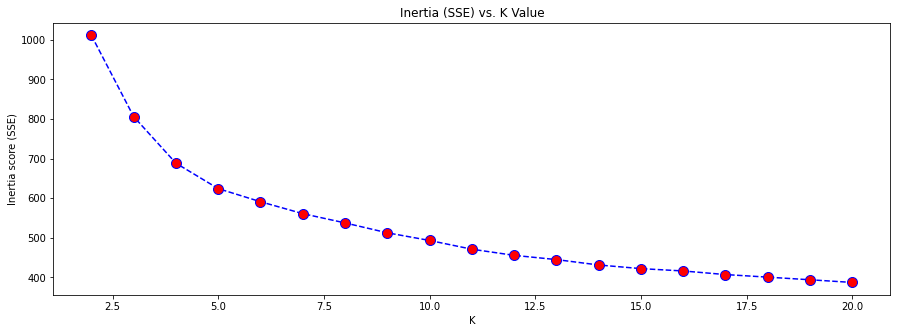

In [50]:
plt.figure(figsize=(15,5))
plt.plot(k1,inertia_s1,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Inertia (SSE) vs. K Value')
plt.xlabel('K')
plt.ylabel('Inertia score (SSE)')

Text(0, 0.5, 'SS')

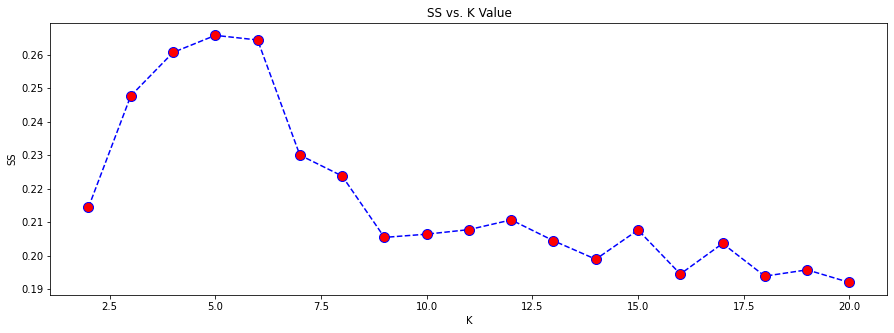

In [51]:
plt.figure(figsize=(15,5))
plt.plot(k1,sscore1,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('SS vs. K Value')
plt.xlabel('K')
plt.ylabel('SS')

<b>Elbow is around 5-6. Using SS score, k can be either 5 or 6 as these have the highest SS scores</b>

<b>Fixing k=6</b>

## Final clustering iteration

In [52]:
kmeans = KMeans(n_clusters=6,random_state=125,max_iter=100).fit(df_clust)
sscore = ss(df_clust,kmeans.labels_)
inertia= kmeans.inertia_

print('sscore',sscore)
print('inertia',inertia)

sscore 0.2644425716291346
inertia 591.0601380602852


In [53]:
# save k-means
pkl_filename = "./files/model_objects/kmeans_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(kmeans, file)

# 3. Profiling

We will use pandas .describe() to get cluster level summaries for profiling the clusters.

<b>Add cluster labels</b>

In [54]:
df_features['cluster_ids'] = kmeans.labels_

<b>Add *age* & *hh_income* from customer table to final features table</b>

In [55]:
df_features = df_features.merge(
    df_customer[['customer_id','age','hh_income']].set_index('customer_id'),
    on='customer_id',how='left')
df_features = df_features.reset_index()

<b>Overall level summary</b>

In [56]:
df_profile_overall = df_features.describe().T

# use median for age and hh_income
df_profile_overall['Overall Dataset'] = df_profile_overall.apply(
    lambda row: row['50%']   if row.name in ['age','hh_income'] else
    row['count'] if row.name in ['customer_id'] else row['mean'],
    axis=1)
df_profile_overall = df_profile_overall[['Overall Dataset']]

<b>Cluster ID level summary</b>

In [57]:
df_cluster_summary = df_features.groupby('cluster_ids').describe().T.reset_index()
df_cluster_summary = df_cluster_summary.rename(columns={'level_0':'column','level_1':'metric'})

In [58]:
# keep median for age & hh_income, count for customer id
df_cluster_summary = df_cluster_summary.query(
    '''
        (column.isin(["age","hh_income"]) & metric == "50%") | \
        (column.isin(["customer_id"]) & metric == "count") | \
        (~column.isin(["customer_id","age","hh_income"]) & metric == "mean")
    ''',
    engine='python')

In [59]:
df_cluster_summary['Metric'] = df_cluster_summary.apply(
    lambda row: 'median' if row['metric']=='50%' else row['metric'],
    axis=1)
df_cluster_summary = df_cluster_summary.set_index('column')
df_cluster_summary = df_cluster_summary.drop('metric', axis=1)

<b>Save profiling table as csv</b>

We will then look at this table in excel to profile the clusters.
- All clusters can be compared to one another and to the overall dataset across all features
- Differences in features across clusters can be combined to describe each cluster
- The data used above does not have any strong differentiating markers except email subscription and omni shopper flags
- In real data you could have clusters such as *high value shoppers*, *low frequency shoppers*, or clusters showing affinity towards a single product category: *category B shoppers*, etc.

<mark>Note</mark>: You could also go back and change the number of clusters in case the profiles aren't satisfactory. There are a few parameters as well that can be changed in the kMeans model.

In [60]:
df_profile = df_cluster_summary.join(df_profile_overall) # joins on Index

In [61]:
df_profile.to_csv('./files/kmeans_profiling.csv')

# 4. Scoring
Once we have a k-means model trained and the clusters profiled, we can setup a scoring process that will assign cluster labels to new data.<br> This can help in tagging customers to particular clusters using latest transactions data and tracking cluster growth/movement over time.

This part of the process most likely will be done using a python script that is scheduled to run at a particular cadence instead of being done via Jupyter. You will have a code or codes that prepare the data in the required format and then a python script that uses the saved scaling and model objects to score the updated data.

In [62]:
# Below process starts after the features dataset is created at customer id level
# Please have required steps done prior to this step to have the features dataset ready

# load features df
df = pd.read_csv('./data/clustering_features.csv').set_index('customer_id')

In [63]:
df.head()

,sales,units,orders,unique_products_bought,unique_payments_used,unique_categories_bought,aov,aur,upt,category_a_sales,category_b_sales,category_c_sales,category_d_sales,category_e_sales,category_a_units,category_b_units,category_c_units,category_d_units,category_e_units,payment_cash,payment_credit,payment_debit,payment_gc,payment_others,email_subscribed,omni_shopper
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2395,11,5,5,3,3,479.000000,217.727273,2.200000,0.480167,NaN,0.450939,NaN,0.068894,0.363636,NaN,0.363636,NaN,0.272727,NaN,0.519833,0.167015,0.313152,NaN,0,0
2,4815,15,7,6,4,3,687.857143,321.000000,2.142857,0.721703,NaN,0.247144,NaN,0.031153,0.466667,NaN,0.333333,NaN,0.200000,0.031153,0.704050,0.186916,0.077882,NaN,1,1
3,4285,21,10,9,4,5,428.500000,204.047619,2.100000,0.240373,0.175029,0.309218,0.210035,0.065344,0.190476,0.238095,0.238095,0.095238,0.238095,NaN,0.263711,0.309218,0.147025,0.280047,0,0
4,12000,44,21,15,4,5,571.428571,272.727273,2.095238,0.575000,0.067500,0.158333,0.170833,0.028333,0.409091,0.159091,0.181818,0.113636,0.136364,0.066667,0.345000,0.370000,0.218333,NaN,1,0
5,1700,8,3,3,2,2,566.666667,212.500000,2.666667,NaN,0.264706,0.735294,NaN,NaN,NaN,0.375000,0.625000,NaN,NaN,NaN,NaN,0.735294,0.264706,NaN,0,0


In [64]:
# fill na
df = df.fillna(0)

# scaling
cols_scale = [
    'sales','units','upt','aur','aov','unique_categories_bought','unique_payments_used',
    'unique_products_bought','orders']

# Load scaler  from file
pkl_filename = "./files/model_objects/kmeans_scaler_model.pkl"
with open(pkl_filename, 'rb') as file:
    scaler = pickle.load(file)

df[cols_scale] = scaler.transform(df[cols_scale])

# Load k-means from file
pkl_filename = "./files/model_objects/kmeans_model.pkl"
with open(pkl_filename, 'rb') as file:
    kmeans = pickle.load(file)

df['cluster_ids'] = kmeans.predict(df)

# save labels
df[['cluster_ids']].to_csv('./files/kmeans_labels.csv', index=True)

In [65]:
df.cluster_ids.value_counts()

0    293
4    284
2    194
1     92
5     82
3     55
Name: cluster_ids, dtype: int64